# Smoothing and Forecasting

Tree rings from [Tree: Les Merveilles, France](https://datamarket.com/data/set/22r2/tree-les-merveilles-france-lade-larix-2150m-4402-00727#!ds=22r2&display=line) years: 988 to 1974


In [45]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

ts = pd.read_csv('../data/tree-rings.csv', parse_dates = ['year'], index_col = 'year', infer_datetime_format = True)
ts.head()

,rings
year,
988,1.484
989,1.119
990,1.057
991,1.081
992,1.073


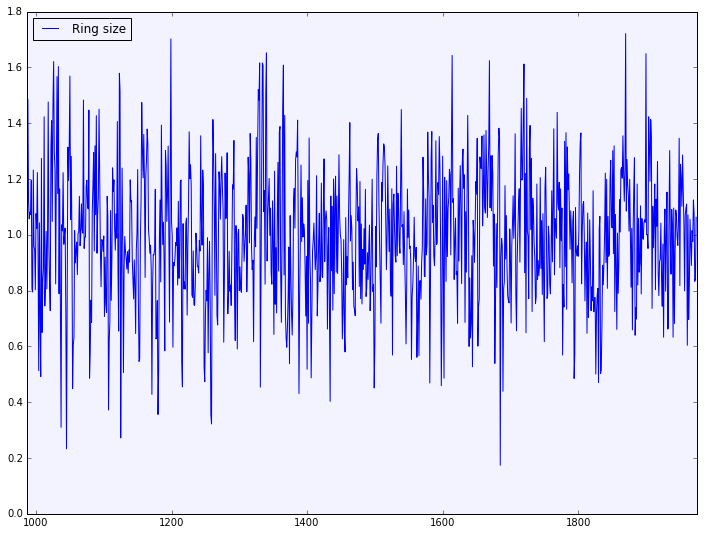

In [46]:
# Plot the time series

fig= plt.figure(figsize=(12,9))
plt.plot(ts.index, ts.rings, label = 'Ring size')
plt.xlim(xmin = min(ts.index)-1, xmax = max(ts.index) +1 )
plt.legend(loc='best')

# 1. Most Simple Forecast


$$ \hat{Y}_{n+1} = Y_n $$

Create a new column *simple* shifted by 1 sample so that 
    
    * ts.simple[0] = None
    * ts.simple[1] = ts.rings[0]
    * ...
    * ts.simple[n] = ts.rings[n-1]



In [47]:
ts['simple'] = ts.rings.shift(1)
ts.head()

,rings,simple
year,,
988,1.484,NaN
989,1.119,1.484
990,1.057,1.119
991,1.081,1.057
992,1.073,1.081


# Metrics

How do we estimate quality of prediction?

Calculate:

* MSE with sklearn.metrics.mean_squared_error
* MAPE

        def mape(y_true, y_pred):
            return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


* MAD: with [pandas.DataFrame.mad](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.mad.html)
        
        def mad(y_true, y_pred):
            return np.mean(np.abs(y_true - y_pred)) 
            


In [55]:
import numpy as np
from sklearn.metrics import mean_squared_error as mse

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
def mad(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred)) 



In [56]:

y_true = ts.rings[1:ts.shape[0]]
y_pred = ts.simple[1:ts.shape[0]]

print("MAPE: %0.2f pct"% mape(y_true, y_pred))
print("MAD: %0.5f"% mad(y_true, y_pred))
print("MSE: %0.4f"% mse(y_true, y_pred))


MAPE: 26.20 pct
MAD: 0.22557
MSE: 0.0842


# 2. Moving average

Use the pandas series [Rolling](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.rolling.html) function

* Window size
* Centering: True

        ts.rings.rolling(window=7).mean()
        ts.rings.rolling(window=7, center= True).mean()

Exercise 1: Plot the series with different size of windows (5 to 25) on the same graph.

Exercize 2: Try different window size, calculate the different metrics, store the results in a dataframe and plot



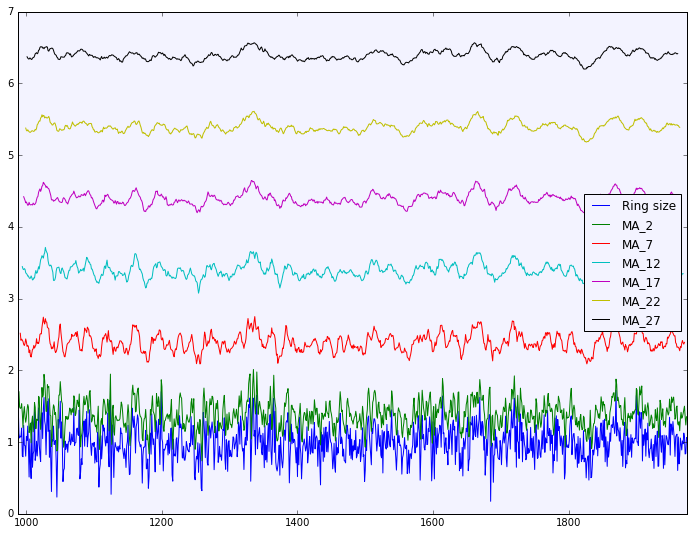

In [73]:
fig= plt.figure(figsize=(12,9))

plt.plot(ts.index, ts.rings, label = 'Ring size')

for window_size in range(2,30, 5):
    smoothed = ts.rings.rolling(window = window_size, center= True).mean() + window_size/5
    plt.plot(ts.index, smoothed , label = 'MA_%s'% window_size )

# window_size= 5
# smoothed_ts = ts.rings.rolling(window= window_size, center= True).mean() 
# plt.plot(ts.index, smoothed_ts + 1, label = 'Smoothed')


plt.xlim(xmin = min(ts.index)-1, xmax = max(ts.index) +1 )
plt.legend(loc='best')


# for i in range(1,25, 5):
#     smoothed = ts.rings.rolling(window=i, center= True).mean() + i/5
#     plt.plot(ts.index, smoothed , label = 'MA_%s'% i )


In [99]:
results = []
for window_size in range(1,30):
    smoothed = ts.rings.rolling(window = window_size, center= False).mean().shift(1)
    cond = ~smoothed.isnull()
    y_true = ts.rings[cond]
    y_pred = smoothed[cond]
    
    results.append([mape(y_true, y_pred), mad(y_true, y_pred), mse(y_true, y_pred)])

results    


[[26.203945080768023, 0.2255669371196754, 0.084210562880324538],
 [24.894167636534814, 0.21101421319796959, 0.073309847208121809],
 [24.147828567145663, 0.20394139566395661, 0.068321370483288152],
 [23.69740683777621, 0.19944455747711085, 0.064889422685656159],
 [23.661457082177652, 0.19865723014256617, 0.063778241181262726],
 [23.750407584129125, 0.19909802922188247, 0.063507937960131391],
 [23.599381793694786, 0.19779227405247815, 0.06267379394002498],
 [23.309756839093478, 0.1958700204290092, 0.061525527196118486],
 [23.076144140152884, 0.19405600999772779, 0.061194766075891839],
 [22.86337620118956, 0.19236438075742068, 0.060296757809621293],
 [22.945124369645097, 0.19304750372578242, 0.060536715722801789],
 [23.240554721337119, 0.19546846153846154, 0.061470584636752125],
 [23.357198400465201, 0.19633636076449218, 0.061827519452510846],
 [23.478623338222185, 0.19711239171927764, 0.062505114892925304],
 [23.51213203594698, 0.1970164609053498, 0.062668708788294475],
 [23.541682883623

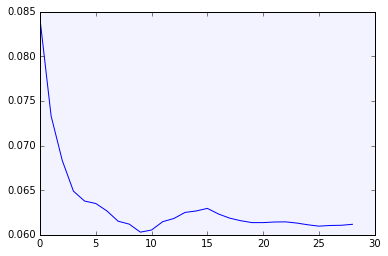

In [100]:
res_ma = pd.DataFrame(results, columns = ['MAPE','MAD','MSE'], )

plt.plot( res_ma.MSE)


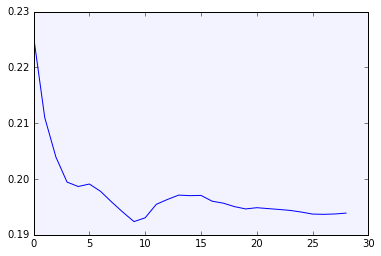

In [101]:
plt.plot(res_ma.MAD)


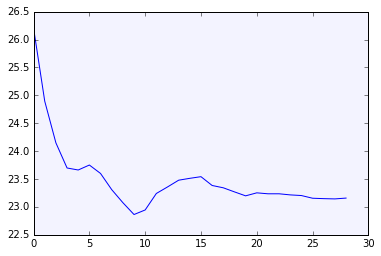

In [102]:
plt.plot(res_ma.MAPE)


# 3. Exponential moving average

Using ts.rings.ewm(alpha = \\( \alpha \\) ).mean() with \\(  0 \lt \alpha \leq 1 \\) 

* Plot the time serie with different values of \\( \alpha \\)
* Calculate MSE, MAD and MAPE 

Is that better than Simple Moving Average?


    for i in np.linspace(0.0001, 1,10):
        plt.plot(ts.index, ts.rings.ewm(alpha = i).mean() + i* 10 , label = 'EWMA: %s'% i)



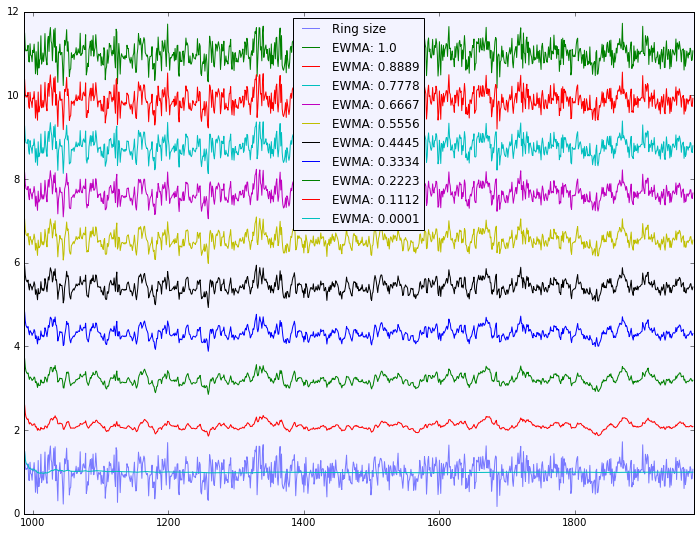

In [103]:
fig= plt.figure(figsize=(12,9))
plt.plot(ts.index, ts.rings, label = 'Ring size', alpha = 0.5)
for i in  np.linspace(1, 0.0001,10):
    plt.plot(ts.index, ts.rings.ewm(alpha = i).mean() + i* 10 , label = 'EWMA: %s'% i)
plt.xlim(xmin = min(ts.index)-1, xmax = max(ts.index) +1 )
plt.legend(loc='best')


In [106]:
results = []
for window_size in np.linspace(0.001, 1,20):
    smoothed = ts.rings.ewm(alpha = window_size).mean().shift(1)
    
    cond = ~smoothed.isnull()
    y_true = ts.rings[cond]
    y_pred = smoothed[cond]
    
    results.append([mape(y_true, y_pred), mad(y_true, y_pred), mse(y_true, y_pred)])

results    


[[22.69901062077593, 0.1895996235630403, 0.058536344939762924],
 [22.686281666033597, 0.18923081196399003, 0.058368187398731612],
 [22.63819596749974, 0.18902092212017374, 0.05810406523943009],
 [22.601385276733577, 0.18892089815901561, 0.058091546435996094],
 [22.628188124787954, 0.18936987067392477, 0.058384874393712344],
 [22.66967780152229, 0.18993777163460704, 0.058936186843108335],
 [22.768814784838163, 0.19103982459988081, 0.059693306343641075],
 [22.912054600357649, 0.19257681466510512, 0.060619153981285472],
 [23.067291481268931, 0.19427866044254144, 0.061691656781703463],
 [23.249067823215604, 0.19621121737486094, 0.062900402043111717],
 [23.439491821249796, 0.19820293694653549, 0.064243279646102824],
 [23.630563023948557, 0.20020193115601417, 0.065723898729233413],
 [23.856615678201877, 0.20245643584194001, 0.067349952106158475],
 [24.118097383941972, 0.2050088118325922, 0.06913244127003787],
 [24.396434446084786, 0.20772773137233982, 0.071085575877013335],
 [24.696779388064

0.058091546435996094

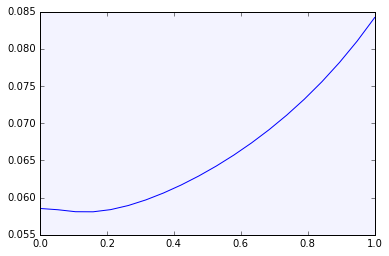

In [111]:
res_ma = pd.DataFrame(results, columns = ['MAPE','MAD','MSE'], )

plt.plot(np.linspace(0.001, 1,20), res_ma.MSE)
min(res_ma.MSE)

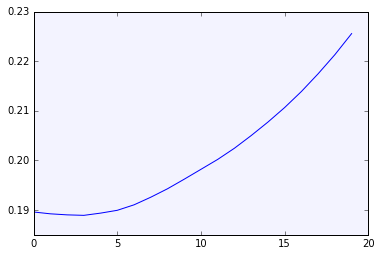

In [108]:
plt.plot( res_ma.MAD)

# 4. Autocorrelation

* Plot the autocorrelation of the tree rings with pandas [autocorrelation_plot()](http://pandas.pydata.org/pandas-docs/stable/visualization.html#visualization-autocorrelation)
* Load the Dow Jownes TS (../data/Dow-Jones.csv) , keep only data points since 2010 and plot the autocorrelation
* Load the average temperature data (../data/mean-daily-temperature.csv)  and plot the autocorrelation

Interpretation?



Index(['Value'], dtype='object')

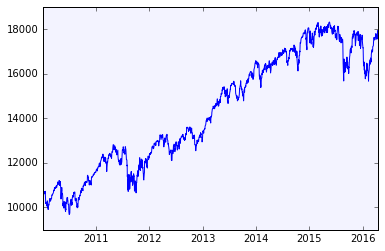

In [121]:
dj = pd.read_csv('../data/Dow-Jones.csv', parse_dates=['Date'], index_col='Date', infer_datetime_format = True)
dj = dj[:'2010-01-01']
plt.plot(dj)


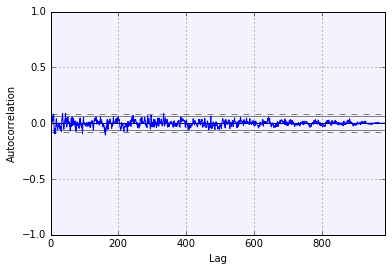

In [124]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(ts.rings)


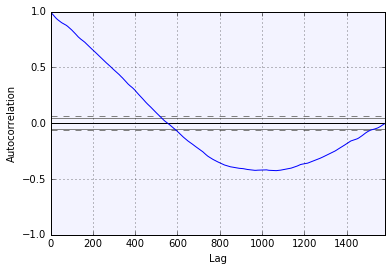

In [123]:
autocorrelation_plot(dj.Value)

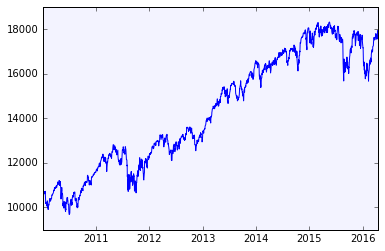

In [130]:
plt.plot(dj)

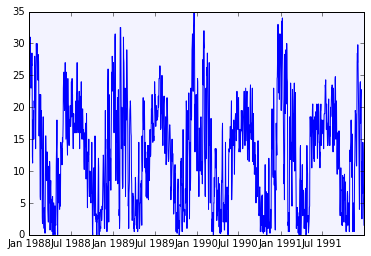

In [127]:
mt = pd.read_csv('../data/mean-daily-temperature.csv', parse_dates=['date'], index_col='date', infer_datetime_format = True)

plt.plot(mt)

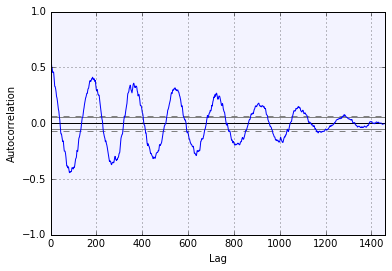

In [129]:
autocorrelation_plot(mt.temp)

# 5. Partial Autocorrelation

Plot the Partial Autocorrelation for the 3 previous datasets.

Interpretation?

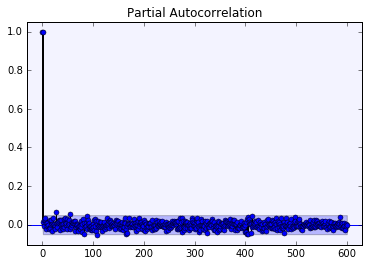

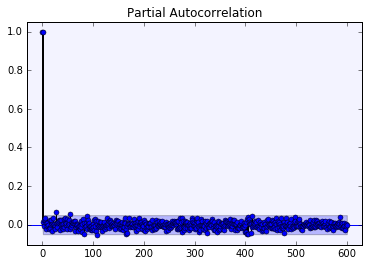

In [144]:
import statsmodels.api as sm
# sm.graphics.tsa.plot_acf(ts.rings, lags=40)
sm.graphics.tsa.plot_pacf(dj.Value, lags=600)


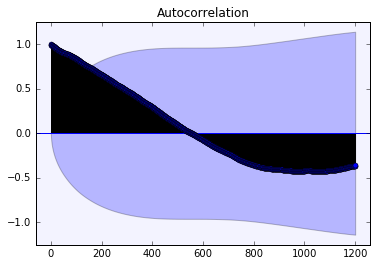

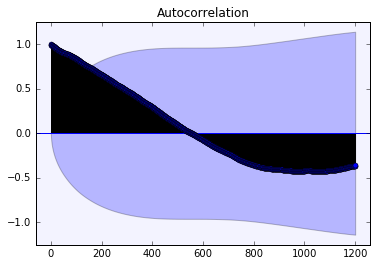

In [147]:
sm.graphics.tsa.plot_acf(dj.Value, lags=1200)

# 6. Stationarity test

Dickey Fuller test

        from statsmodels.tsa.stattools import adfuller
        def test_stationarity(timeseries):

            #Perform Dickey-Fuller test:
            print('Results of Dickey-Fuller Test:')
            dftest = adfuller(timeseries, autolag='AIC')

            dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
            for key,value in dftest[4].items():
                dfoutput['Critical Value (%s)'%key] = value
            print(dfoutput)

Then

        test_stationarity(ts.rings)
        test_stationarity(ts.temp)


What Ts is the most / least stationnary?


In [151]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)



test_stationarity(ts.rings)


Results of Dickey-Fuller Test:
Test Statistic                -8.895119e+00
p-value                        1.212794e-14
#Lags Used                     1.300000e+01
Number of Observations Used    9.730000e+02
Critical Value (1%)           -3.437089e+00
Critical Value (5%)           -2.864515e+00
Critical Value (10%)          -2.568354e+00
dtype: float64


In [153]:
test_stationarity(dj.Value)

Results of Dickey-Fuller Test:
Test Statistic                   -0.750283
p-value                           0.833292
#Lags Used                        5.000000
Number of Observations Used    1576.000000
Critical Value (1%)              -3.434506
Critical Value (5%)              -2.863376
Critical Value (10%)             -2.567747
dtype: float64


In [154]:
test_stationarity(mt.temp)

Results of Dickey-Fuller Test:
Test Statistic                   -4.563489
p-value                           0.000151
#Lags Used                       14.000000
Number of Observations Used    1446.000000
Critical Value (1%)              -3.434880
Critical Value (5%)              -2.863541
Critical Value (10%)             -2.567835
dtype: float64


In [161]:
# Milk production
ts = pd.read_csv('../data/monthly-milk-production-pounds-p.csv', parse_dates = ['month'], index_col = 'month', infer_datetime_format = True)
ts.columns = ['milk']
# ts.head()
# ts.columns

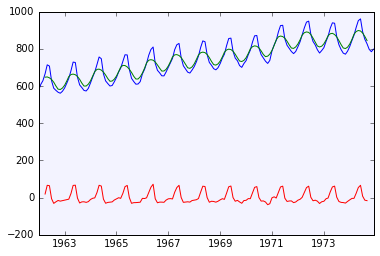

In [172]:
ts['ma'] = ts.milk.rolling(window=7, center= True).mean()

ts['flat'] = ts.milk - ts.ma + 1

plt.plot(ts)


In [176]:
ts.dropna(inplace = True)
test_stationarity(ts.milk)

Results of Dickey-Fuller Test:
Test Statistic                  -0.836607
p-value                          0.808132
#Lags Used                      12.000000
Number of Observations Used    137.000000
Critical Value (1%)             -3.479007
Critical Value (5%)             -2.882878
Critical Value (10%)            -2.578149
dtype: float64


In [177]:
test_stationarity(ts.flat)

Results of Dickey-Fuller Test:
Test Statistic                -5.764826e+00
p-value                        5.563974e-07
#Lags Used                     1.200000e+01
Number of Observations Used    1.370000e+02
Critical Value (1%)           -3.479007e+00
Critical Value (5%)           -2.882878e+00
Critical Value (10%)          -2.578149e+00
dtype: float64
